## Bayesian Electron Temperature Gradient Model
Trey Wenger - April 2025

In [63]:
import pymc as pm
import arviz as az
import pytensor.tensor as pt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import utils

In [2]:
data = pd.read_csv('hii_data.csv')

In [3]:
data = data[~np.isnan(data['te'])]

In [4]:
data

,gname,glong,glat,radius,vlsr,e_vlsr,line,e_line,line_unit,beam_area,...,telescope,kdar,Rgal,near,far,tangent,vlsr_tangent,plx,dist_author,te_priority
10,G001.125-00.106,1.12515,-0.105151,60.0000,-19.91,0.10,497.533641,2.841245,mJy/beam,41770.00,...,NRAO 140 Foot,NaN,NaN,NaN,NaN,8.172071,33.619886,NaN,NaN,0
13,G001.330+00.088,1.33000,0.088000,42.5000,-12.00,0.20,46.748682,0.829353,mJy/beam,8177.61,...,ATCA,NaN,NaN,NaN,NaN,8.162181,37.191350,NaN,NaN,0
22,G002.889-00.044,2.88951,-0.043949,283.6240,-2.08,0.16,93.866330,1.332930,mJy/beam,41770.00,...,NRAO 140 Foot,NaN,9.690705,0.010000,17.845629,8.158885,56.084607,NaN,NaN,0
24,G003.266-00.061,3.26676,-0.060737,392.7100,7.10,0.16,175.946753,2.209858,mJy/beam,41770.00,...,NRAO 140 Foot,NaN,5.265668,2.898216,13.403351,8.147830,60.019730,NaN,NaN,0
28,G003.650-00.122,3.65037,-0.121412,72.4987,5.10,0.30,55.312332,1.681843,mJy/beam,20478.46,...,ATCA,NaN,6.120989,2.062428,14.185033,8.149430,63.772958,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1867,G354.465+00.079,354.46500,0.079293,175.8950,18.80,0.20,108.915053,1.348748,mJy/beam,20553.78,...,ATCA,NaN,NaN,NaN,NaN,8.129303,-78.809866,NaN,NaN,0
1870,G354.936+00.330,354.93600,0.330387,68.8062,17.80,0.20,34.830717,0.561601,mJy/beam,5139.51,...,ATCA,NaN,NaN,NaN,NaN,8.132483,-75.337929,NaN,NaN,0
1873,G355.344+00.145,355.34400,0.145000,42.5000,18.80,0.30,31.888729,0.599677,mJy/beam,1101.07,...,ATCA,NaN,NaN,NaN,NaN,8.137051,-72.797766,NaN,NaN,0
1876,G356.310-00.206,356.31000,-0.205516,87.7147,-6.40,0.10,57.943719,0.597713,mJy/beam,5120.58,...,ATCA,NaN,5.922102,2.252456,14.052648,8.153702,-64.573279,NaN,NaN,0


In [43]:
prior_Rgal = 10.0 # width of Galactocentric radius prior (kpc)
prior_Te_Rgal_offset = [4350.0, 1000.0] # mean and width of Te vs. Rgal offset prior (K)
prior_Te_Rgal_slope = [375.0, 100.0] # mean and width of Te. vs Rgal slope prior (K/kpc)
prior_Te_sigma = 1000.0 # width of intrinsic Te scatter prior (K)
prior_vlsr_stream = 20.0 # width of streaming velocity prior (km/s)
prior_Te_outlier_mean = 10000.0 # width of outlier mean Te prior (K)
prior_Te_outlier_sigma = 10000.0, # width of outlier Te scatter prior (K)

with pm.Model(coords={"data": data.index, "outlier": [True, False]}) as model:
    # Minimum Galactocentric radius (kpc)
    is_q3_q4 = np.cos(np.deg2rad(data["glong"])) < 0.0
    Rmin = utils.__R0 * np.abs(np.sin(np.deg2rad(data["glong"])))
    Rmin[is_q3_q4] = utils.__R0
    Rmin = pm.Data("Rmin", Rmin, dims="data")

    # Save data
    glong = pm.Data("glong", np.deg2rad(data["glong"]), dims="data")
    glat = pm.Data("glat", np.deg2rad(data["glat"]), dims="data")
    
    # Galactocentric radius offset (kpc)
    Rgal_off_norm = pm.HalfNormal("Rgal_off_norm", sigma=1.0, dims="data")
    Rgal = pm.Deterministic("Rgal", Rmin + prior_Rgal * Rgal_off_norm, dims="data")
    
    # Electron temperature gradient offset (K)
    Te_Rgal_offset_norm = pm.Normal("Te_Rgal_offset_norm", mu=0.0, sigma=1.0)
    Te_Rgal_offset = pm.Deterministic(
        "Te_Rgal_offset",
        prior_Te_Rgal_offset[0] + prior_Te_Rgal_offset[1] * Te_Rgal_offset_norm,
    )
    
    # Electron temperature gradient slope (K)
    Te_Rgal_slope_norm = pm.Normal("Te_Rgal_slope_norm", mu=0.0, sigma=1.0)
    Te_Rgal_slope = pm.Deterministic(
        "Te_Rgal_slope",
        prior_Te_Rgal_slope[0] + prior_Te_Rgal_slope[1] * Te_Rgal_slope_norm,
    )

    # Electron temperature intrinsic scatter (K)
    Te_sigma_norm = pm.HalfNormal("Te_sigma_norm", sigma=1.0)
    Te_sigma = pm.Deterministic("Te_sigma", prior_Te_sigma * Te_sigma_norm)

    # Streaming velocity (km/s)
    vlsr_stream_norm = pm.HalfNormal("vlsr_stream_norm", sigma=1.0)
    vlsr_stream = pm.Deterministic("vlsr_stream", prior_vlsr_stream * vlsr_stream_norm)

    # LSR velocity (km/s)
    vlsr = utils.reid19_vlsr(glong, glat, Rgal)

    # Electron temperature (K)
    Te = Te_Rgal_offset + Te_Rgal_slope * Rgal

    # Outlier Te distribution
    Te_outlier_mean_norm = pm.HalfNormal("Te_outlier_mean_norm", sigma=1.0)
    Te_outlier_mean = pm.Deterministic("Te_outlier_mean", prior_Te_outlier_mean * Te_outlier_mean_norm)
    Te_outlier_sigma_norm = pm.HalfNormal("Te_outlier_sigma_norm", sigma=1.0)
    Te_outlier_sigma = pm.Deterministic("Te_outlier_sigma", prior_Te_outlier_sigma * Te_outlier_sigma_norm)

    # Mixture weights
    outlier_weight = pm.Dirichlet("outlier_weight", np.ones(2), dims="outlier")

    # LSR velocity likelihood (km/s)
    vlsr_like_sigma = pt.sqrt(vlsr_stream**2.0 + data["e_vlsr"]**2.0)
    _ = pm.Normal("vlsr", mu=vlsr, sigma=vlsr_like_sigma, observed=data["vlsr"], dims="data")

    # Electron temperature likelihood (K)
    Te_like_sigma = pt.sqrt(Te_sigma**2.0 + data["e_te"]**2.0)
    Te_outlier_like_sigma = pt.sqrt(Te_outlier_sigma**2.0 + data["e_te"]**2.0)
    comp_dists = [
        pm.Normal.dist(mu=Te_outlier_mean, sigma=Te_outlier_like_sigma),
        pm.Normal.dist(mu=Te, sigma=Te_like_sigma)
    ]
    _ = pm.Mixture("Te", comp_dists=comp_dists, w=outlier_weight, observed=data["te"], dims="data")

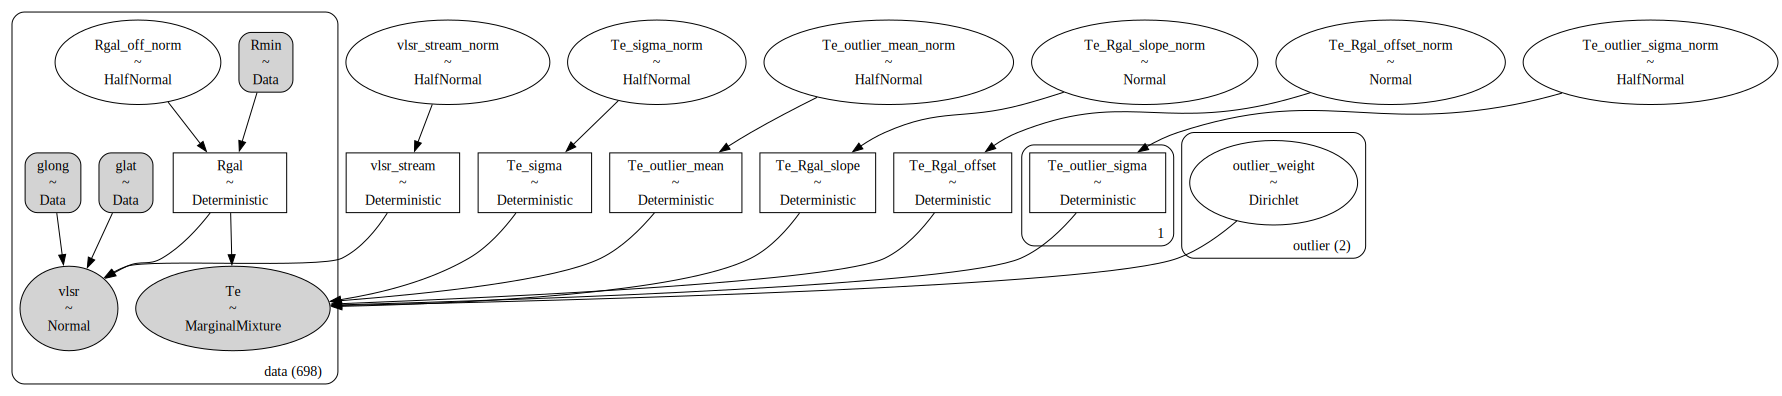

In [44]:
model.to_graphviz()

In [56]:
with model:
    trace = pm.sample(5000, tune=1000, chains=4, cores=4, target_accept=0.8)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Rgal_off_norm, Te_Rgal_offset_norm, Te_Rgal_slope_norm, Te_sigma_norm, vlsr_stream_norm, Te_outlier_mean_norm, Te_outlier_sigma_norm, outlier_weight]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 166 seconds.


In [60]:
var_names = ["Te_Rgal_slope", "Te_Rgal_offset", "Te_sigma", "Te_outlier_mean", "Te_outlier_sigma", "vlsr_stream", "outlier_weight"]
az.summary(trace, var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Te_Rgal_slope,412.135,16.217,382.588,443.965,0.169,0.111,9189.0,12703.0,1.00
Te_Rgal_offset,3654.044,111.401,3442.516,3862.961,0.957,0.744,13570.0,14059.0,1.00
Te_sigma,632.892,35.473,566.271,700.115,0.513,0.233,4777.0,10483.0,1.00
Te_outlier_mean,8012.441,671.555,6726.267,9102.514,11.374,4.371,3778.0,8561.0,1.00
Te_outlier_sigma[0],1354.347,455.995,605.498,2165.999,7.025,3.342,4552.0,11225.0,1.00
vlsr_stream,16.264,1.969,12.745,19.967,0.061,0.031,1018.0,2215.0,1.01
outlier_weight[True],0.045,0.020,0.014,0.083,0.000,0.000,6143.0,9100.0,1.00
outlier_weight[False],0.955,0.020,0.917,0.986,0.000,0.000,6143.0,9100.0,1.00


array([[<Axes: title={'center': 'Te_Rgal_slope'}>,
        <Axes: title={'center': 'Te_Rgal_slope'}>],
       [<Axes: title={'center': 'Te_Rgal_offset'}>,
        <Axes: title={'center': 'Te_Rgal_offset'}>],
       [<Axes: title={'center': 'Te_sigma'}>,
        <Axes: title={'center': 'Te_sigma'}>],
       [<Axes: title={'center': 'Te_outlier_mean'}>,
        <Axes: title={'center': 'Te_outlier_mean'}>],
       [<Axes: title={'center': 'Te_outlier_sigma'}>,
        <Axes: title={'center': 'Te_outlier_sigma'}>],
       [<Axes: title={'center': 'vlsr_stream'}>,
        <Axes: title={'center': 'vlsr_stream'}>],
       [<Axes: title={'center': 'outlier_weight'}>,
        <Axes: title={'center': 'outlier_weight'}>]], dtype=object)

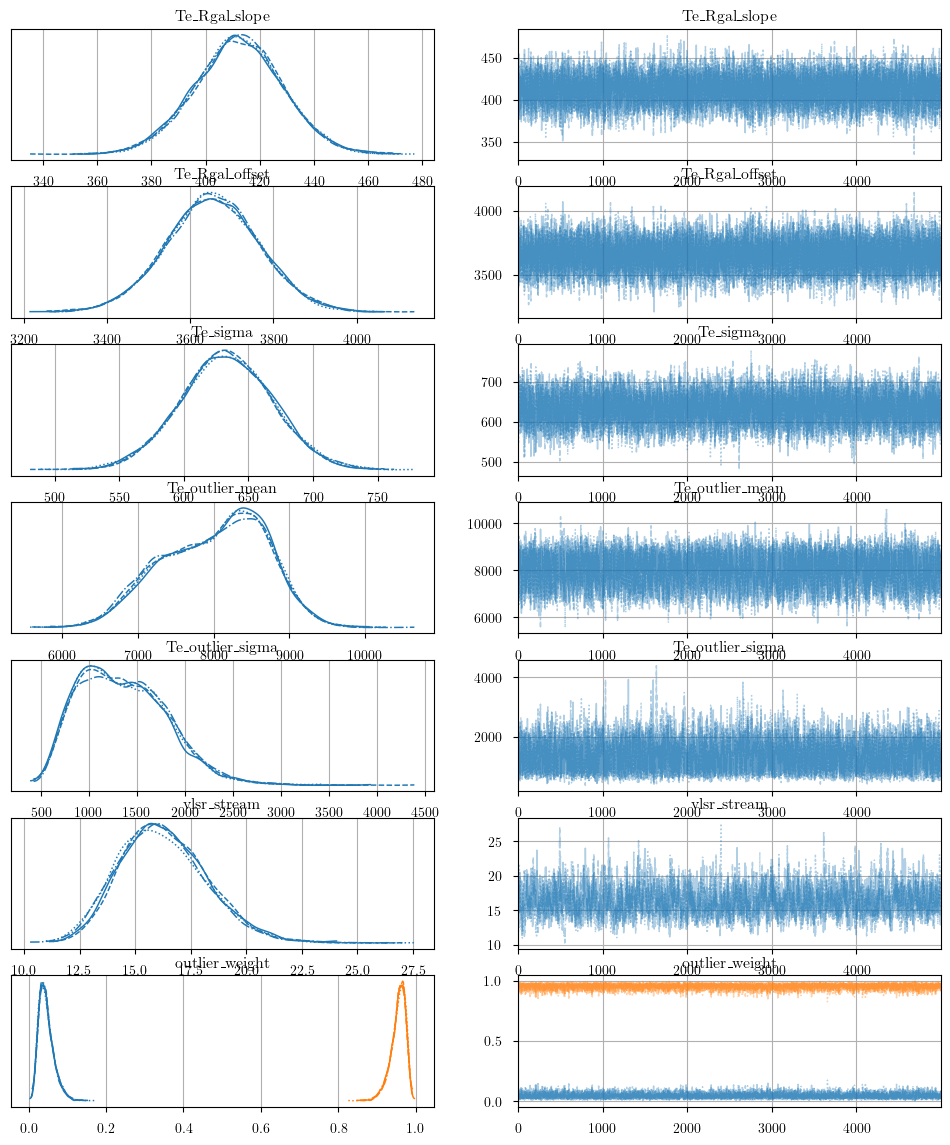

In [61]:
az.plot_trace(trace, var_names=var_names)

array([[<Axes: ylabel='Te_Rgal_offset'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='Te_sigma'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='Te_outlier_mean'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='Te_outlier_sigma\n0'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='vlsr_stream'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='outlier_weight\nTrue'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='Te_Rgal_slope', ylabel='outlier_weight\nFalse'>,
        <Axes: xlabel='Te_Rgal_offset'>, <Axes: xlabel='Te_sigma'>,
        <Axes: xlabel='Te_outlier_mean'>,
        <Axes: xlabel='Te_outlier_sigma\n0'>,
        <Axes: xlabel='vlsr_stream'>,
        <Axes: xlabel='outlier_weight\nTrue'>]], dtype=object)

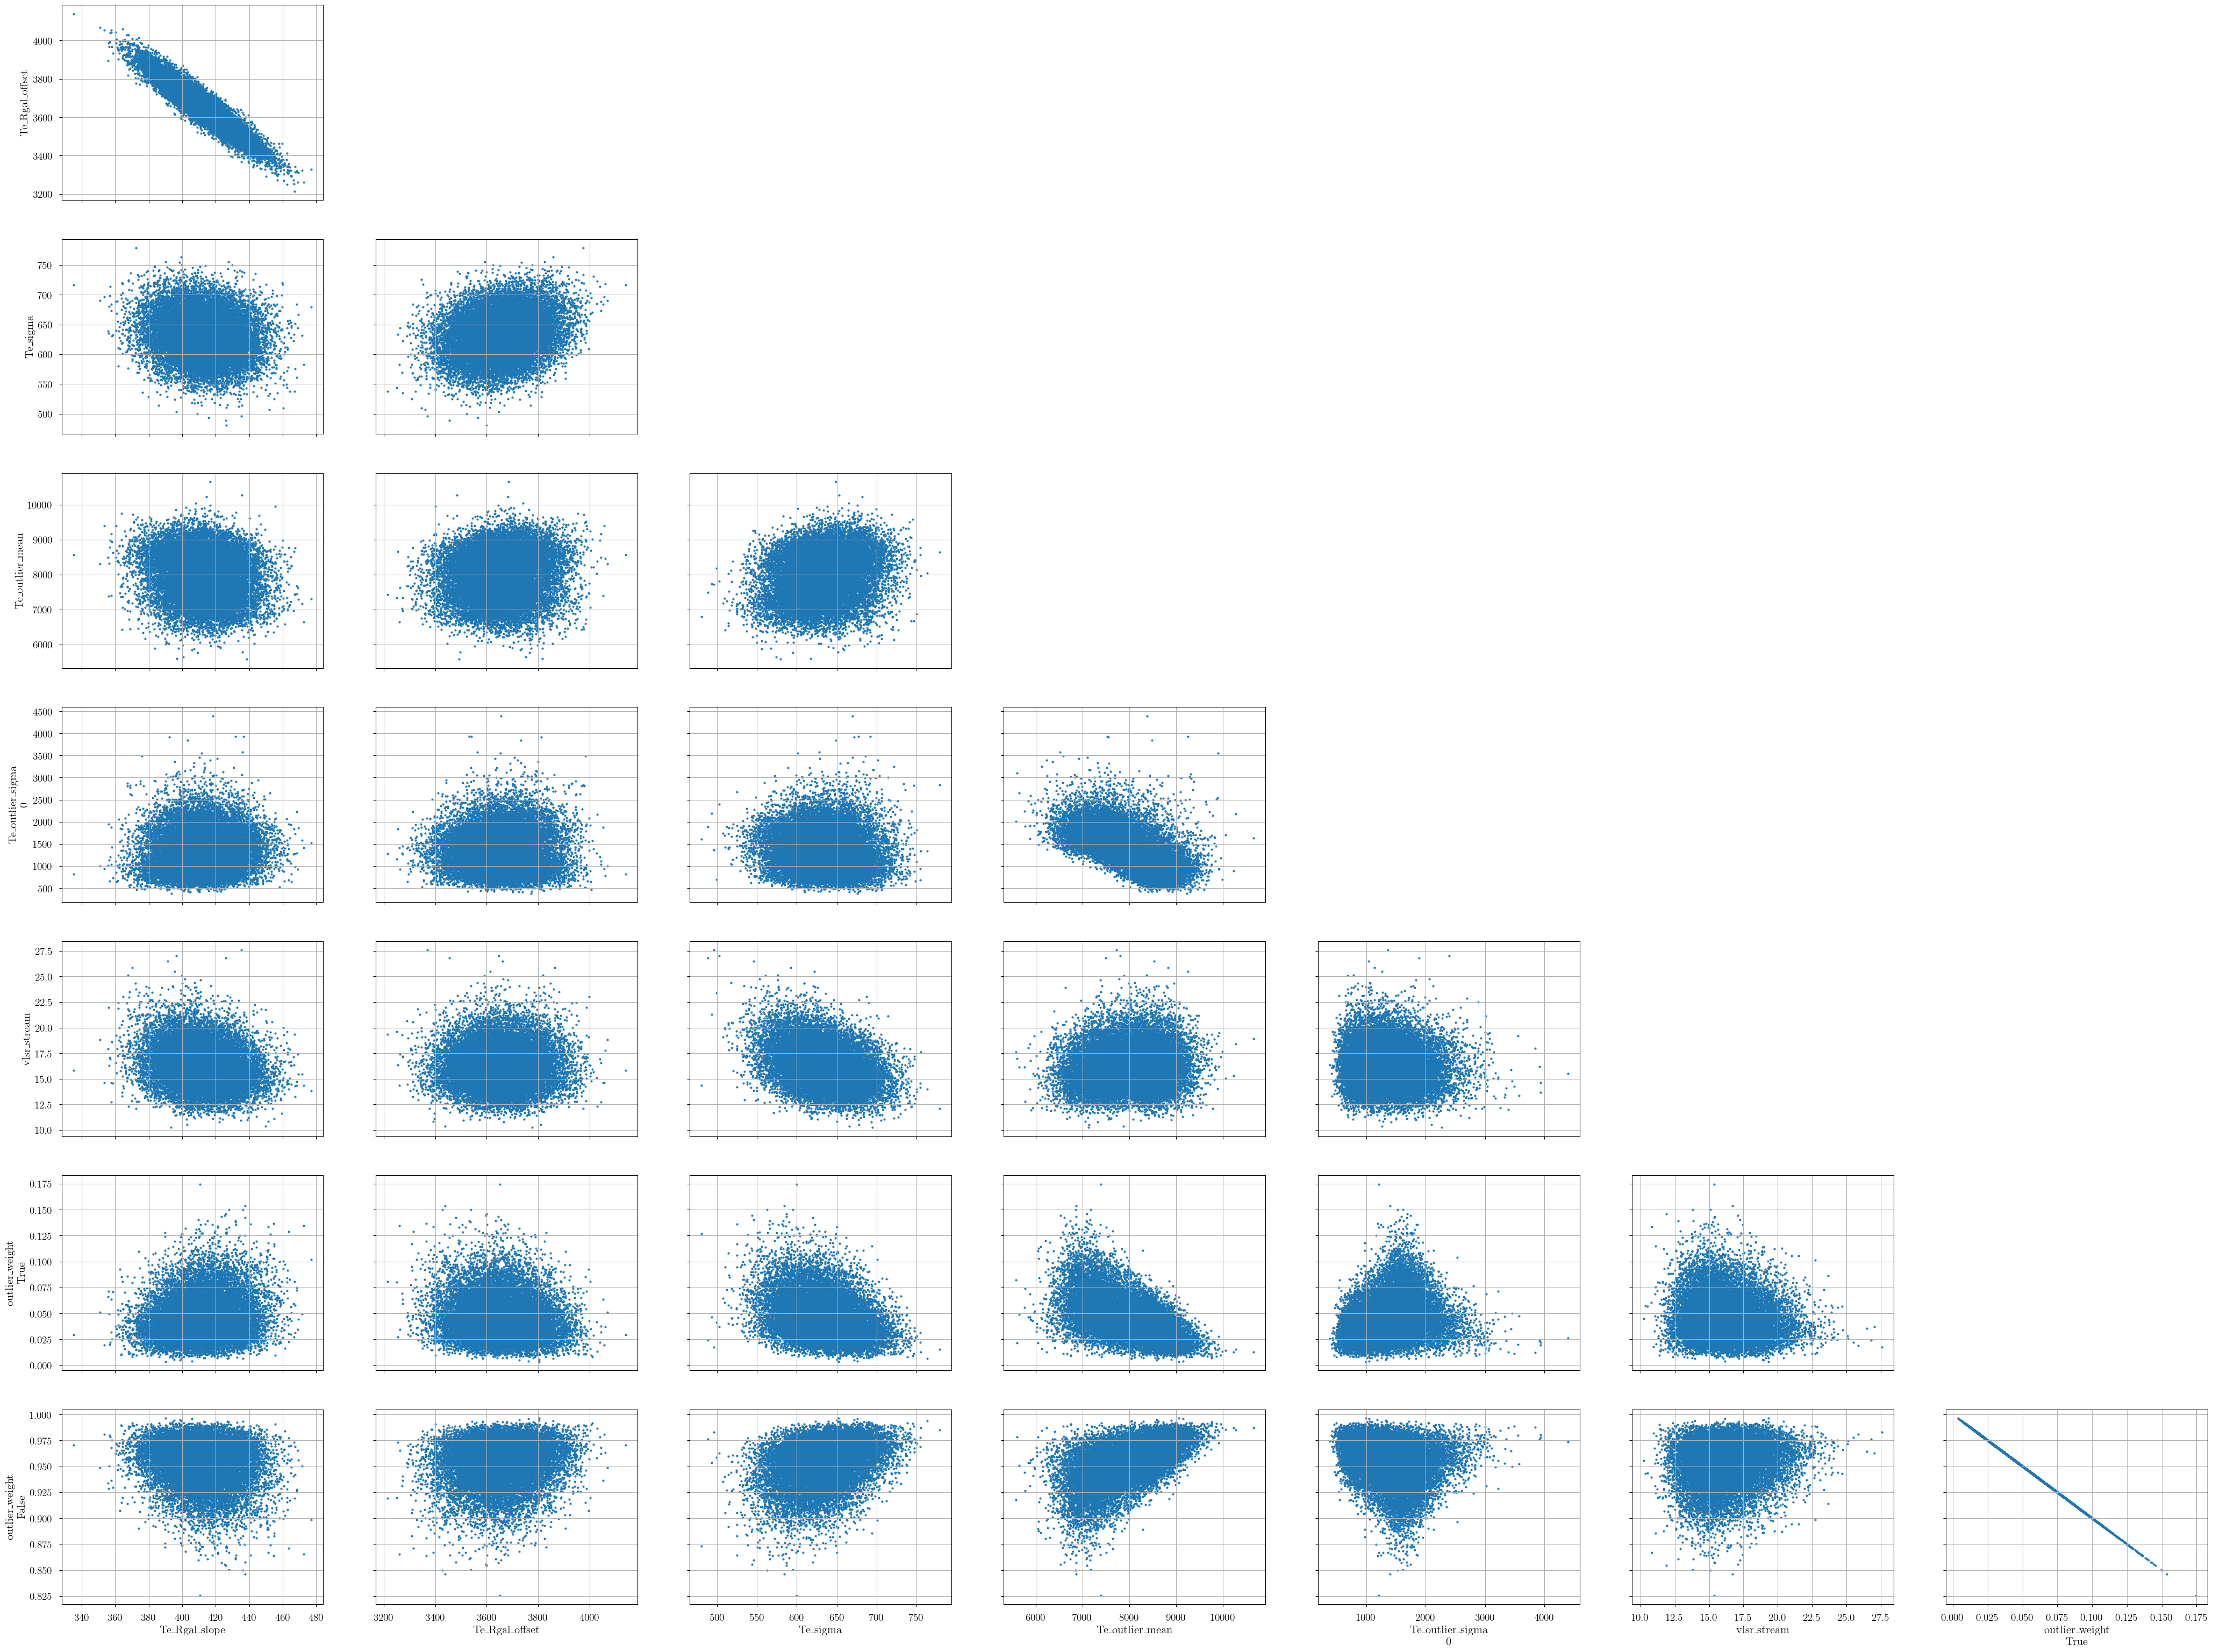

In [62]:
az.plot_pair(trace, var_names=var_names, kind="scatter")

Text(0, 0.5, '$T_e$ (K)')

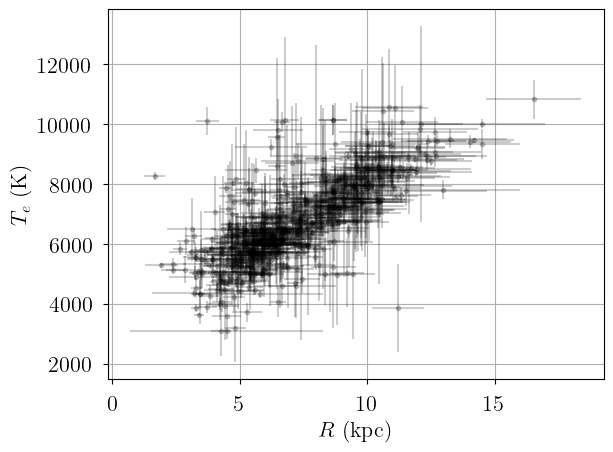

In [71]:
fig, ax = plt.subplots()
ax.errorbar(
    trace.posterior["Rgal"].mean(dim=["chain", "draw"]),
    data["te"],
    xerr=trace.posterior["Rgal"].std(dim=["chain", "draw"]),
    yerr=data["e_te"],
    marker=".",
    color="k",
    linestyle="none",
    alpha=0.2,
)
ax.set_xlabel(r"$R$ (kpc)")
ax.set_ylabel(r"$T_e$ (K)")

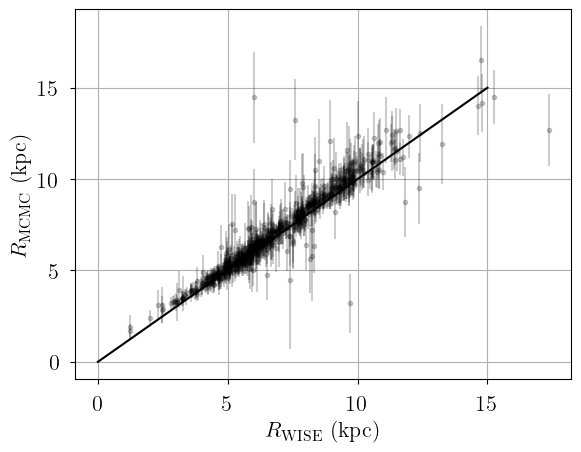

In [73]:
fig, ax = plt.subplots()
ax.errorbar(
    data["Rgal"],
    trace.posterior["Rgal"].mean(dim=["chain", "draw"]),
    yerr=trace.posterior["Rgal"].std(dim=["chain", "draw"]),
    marker=".",
    color="k",
    linestyle="none",
    alpha=0.2,
)
ax.set_xlabel(r"$R_{\rm WISE}$ (kpc)")
ax.set_ylabel(r"$R_{\rm MCMC}$ (kpc)")
ax.plot([0.0, 15.0], [0.0, 15.0], 'k-')